The `flexcode` package can be installed directly by cloning the Github repository:

<code style="background:black;color:white">git clone https://github.com/tpospisi/FlexCode.git </code> <br>
<code style="background:black;color:white">python setup.py install </code> 

In [1]:
import numpy as np
import flexcode
from cdetools.cde_loss import cde_loss
from matplotlib import pyplot as plt
from flexcode.regression_models import RandomForest

In the following cell we run the `wget` module to fetch the data from the [COINtoolbox Github repository](https://github.com/COINtoolbox/photoz_catalogues/tree/master/Teddy). <br>
You can download the Teddy A and B manually if you prefer.

In [2]:
import os
import wget

data_dir = 'data/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print('"data" subfolder created')
    
_ = wget.download('https://github.com/COINtoolbox/photoz_catalogues/raw/master/Teddy/teddy_A', 
              out='data/teddy_A.txt')

_ = wget.download('https://github.com/COINtoolbox/photoz_catalogues/raw/master/Teddy/teddy_B', 
              out='data/teddy_B.txt')

The following lines assume you have the datasets `Teddy A` and `Teddy B` in a subfolder of your current directory. By default this subfolder is `data`, but it can be changed below. The following function extract the information from the .txt file and generates numpy array. <br> <br>

You can find the `Teddy A` and `Teddy B` dataset in the [COINtoolbox Github repository](https://github.com/COINtoolbox/photoz_catalogues/tree/master/Teddy).

In [3]:
def extract_teddy_data(filename, train_data, directory='data/'):
    
    full_data = []
    outfiles = ('teddy_x_train.npy', 'teddy_z_train.npy') if train_data else ('teddy_x_test.npy', 'teddy_z_test.npy')
    with open(filename) as fp:
        full_lines = fp.readlines()
        for line in full_lines:
            if '#' in line:
                continue
            full_data.append([float(el) for el in line.strip().split(' ') if el])
        fp.close()
    
    # Saving the formatted Teddy data
    np.save(arr=np.array(full_data)[:, 7:12], file=directory + outfiles[0])
    np.save(arr=np.array(full_data)[:, 6], file=directory + outfiles[1])
    print('Extraction and Saving Done!')

In [4]:
extract_teddy_data(filename='data/teddy_A.txt', train_data=True, directory='data/')

Extraction and Saving Done!


In [5]:
extract_teddy_data(filename='data/teddy_B.txt', train_data=False, directory='data/')

Extraction and Saving Done!


## Load Teddy Cosmology Data

The $\texttt{TEDDY}$ data are comprised of 4 datasets, generated by subsampling from the [SDSS DR12](https://www.sdss.org/dr12/). <br>
The 4 datasets are named respectively A, B, C and D.

We use dataset A for training and B for testing.<br>
Data in these two datasets share the same underlying distribution, so training-based algorithms do not need any further adjustments. <br>
For more information, consult the [TEDDY Github Repo](https://github.com/COINtoolbox/photoz_catalogues/tree/master/Teddy).

Both datasets have around 74,000 spectroscopic samples in it. <br>
We downsample both training and testing, including only the first 2,000 and 500 galaxies respectively. <br>
Here we also use a validation set of 500 galaxies, taken from the training set.

In [6]:
train_limit_points = 2000
valid_limit_points = 500
test_limit_points = 500

x_train = np.load(file='data/teddy_x_train.npy')[:train_limit_points, :]
x_validation = np.load(file='data/teddy_x_train.npy')[train_limit_points:train_limit_points + valid_limit_points, :]
x_test = np.load(file='data/teddy_x_test.npy')[:test_limit_points, :]

z_train = np.load(file='data/teddy_y_train.npy')[:train_limit_points]
z_validation = np.load(file='data/teddy_y_train.npy')[train_limit_points:train_limit_points + valid_limit_points]
z_test = np.load(file='data/teddy_y_test.npy')[:test_limit_points]

## Running Flexcode

As any $\texttt{sklearn}$ model, with the first call we initialize the model. <br>
We need to specify the following:
* regression model hyper-parameters; here we include those for Random Forest:
    - the number of trees `n_estimators`, 
    - the maximum depth of a tree with `max_depth` and 
    - the splitting criterion `criterion`.
* we also pass in the basis system and the maximum number of basis we want Flexcode to consider. Currently, Flexcode will automatically select the best number of basis according to the training data available.

In [7]:
n_estimators = 100
criterion = 'mse'
max_depth = 5

max_basis = 31
basis_system = 'cosine'

model = flexcode.FlexCodeModel(RandomForest, max_basis=max_basis, basis_system=basis_system,
                             regression_params={'max_depth': max_depth, 'n_estimators': n_estimators, 
                                                'criterion': criterion})

We then train the model by using the `train` method

In [8]:
model.fit(x_train, z_train)

For prediction, we only need to specify the number of points `n_grid` in the  CDE support, i.e. the grid over which we want the CDE to be predicted. <br>
Flexcode creates a grid with that number of points between the minimum and maximum of the response in the training data.

In [9]:
n_grid = 1000
cde_test, z_grid = model.predict(x_test, n_grid=n_grid)

In [10]:
model.__dict__

{'max_basis': 31,
 'best_basis': range(0, 31),
 'basis_system': 'cosine',
 'model': <flexcode.regression_models.RandomForest at 0x11eb9cba8>,
 'z_min': array([0.127902]),
 'z_max': array([0.915344]),
 'bump_threshold': None,
 'sharpen_alpha': None}

For Flexcode CDE predictions, `cde_test` is a numpy array, but the actual full conditional density estimates is completely identified by the `n_basis` coefficients. In other words, one can achieve any resolution by just storing `n_basis` floats. <br>
Densities are also normalized, i.e. they integrate to 1.

In [11]:
from scipy.integrate import simps

print(type(cde_test), cde_test.shape)

den_integral = simps(cde_test[0, :], x=np.linspace(model.z_min[0], model.z_max[0], n_grid))
print('Integral of the first density integrates to: %.2f' % den_integral)

<class 'numpy.ndarray'> (500, 1000)
Integral of the first density integrates to: 1.00


### Visualize Predicted CDEs

We can calculate the CDE loss function importing the function from the [`cdetools` package](https://github.com/tpospisi/cdetools).

In [12]:
cde_loss_val, std_cde_loss = cde_loss(cde_test, z_grid, z_test)
print('CDE Loss: %4.2f \pm %.2f' % (cde_loss_val, std_cde_loss))

CDE Loss: -12.20 \pm 0.48


We here visualize the first 12 CDEs

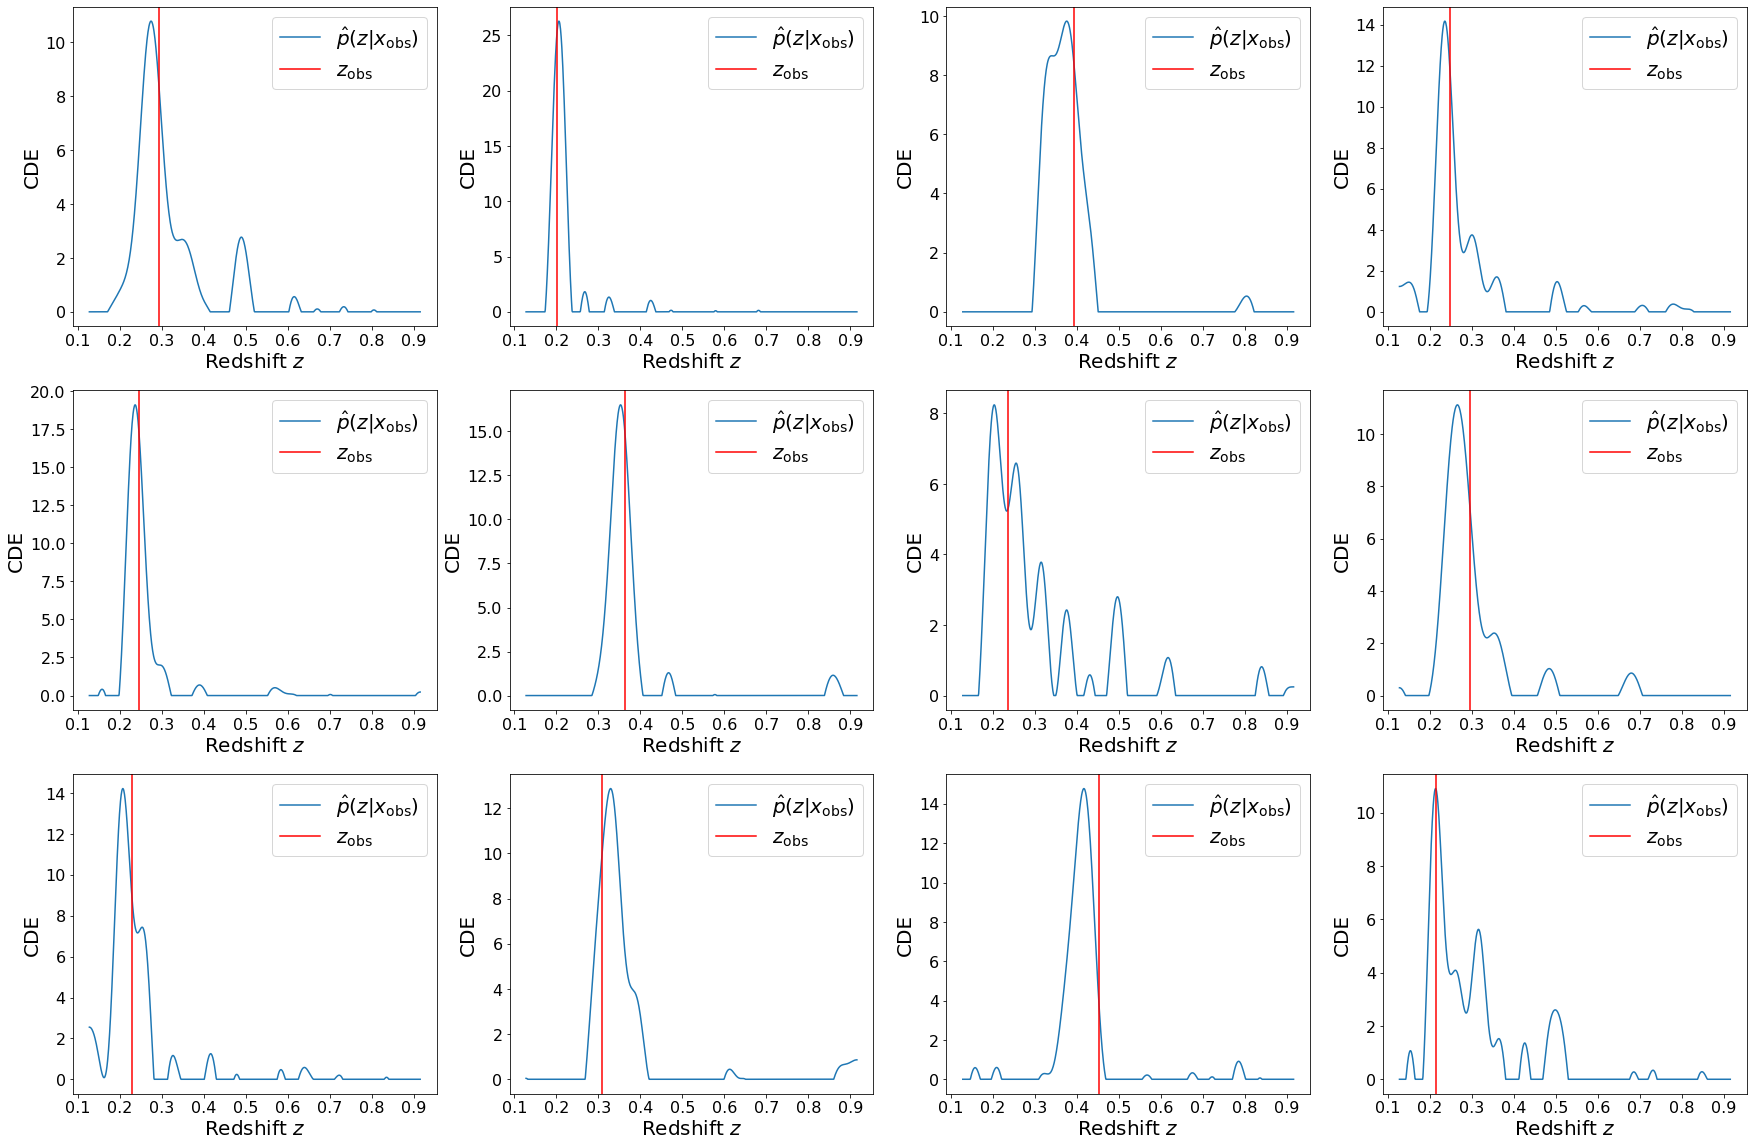

In [13]:
fig = plt.figure(figsize=(30, 20))
for jj, cde_predicted in enumerate(cde_test[:12,:]):
    ax = fig.add_subplot(3, 4, jj + 1)
    plt.plot(z_grid, cde_predicted, label=r'$\hat{p}(z| x_{\rm obs})$')
    plt.axvline(z_test[jj], color='red', label=r'$z_{\rm obs}$')
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel(r'Redshift $z$', size=20)
    plt.ylabel('CDE', size=20)
    plt.legend(loc='upper right', prop={'size': 20})
plt.show()

### Remove Basis Bumps

Basys systems can create artificial "bumps" in the conditional distribution. <br>
Flexcode allows to remove those bumps by selecting a threshold in density. The best threshold is chosen according to its CDE loss. <br>
We can use the method `tune` and pass an array of thresholds.

In [14]:
threshold_vec = [5e-2, 1e-1, 5e-1]
model.tune(x_validation, z_validation, bump_threshold_grid=threshold_vec, n_grid=n_grid)
print('Best Bump Removal Threshold: %s' % model.bump_threshold)

Best Bump Removal Threshold: 0.05


The model saves internally the best bump thresholds, and so the next time the `predict` method is called the density will be adjusted accordingly.

In [15]:
cde_test, z_grid = model.predict(x_test, n_grid=n_grid)

In [16]:
cde_loss_val, std_cde_loss = cde_loss(cde_test, z_grid, z_test)
print('CDE Loss: %4.2f \pm %.2f' % (cde_loss_val, std_cde_loss))

CDE Loss: -12.30 \pm 0.51


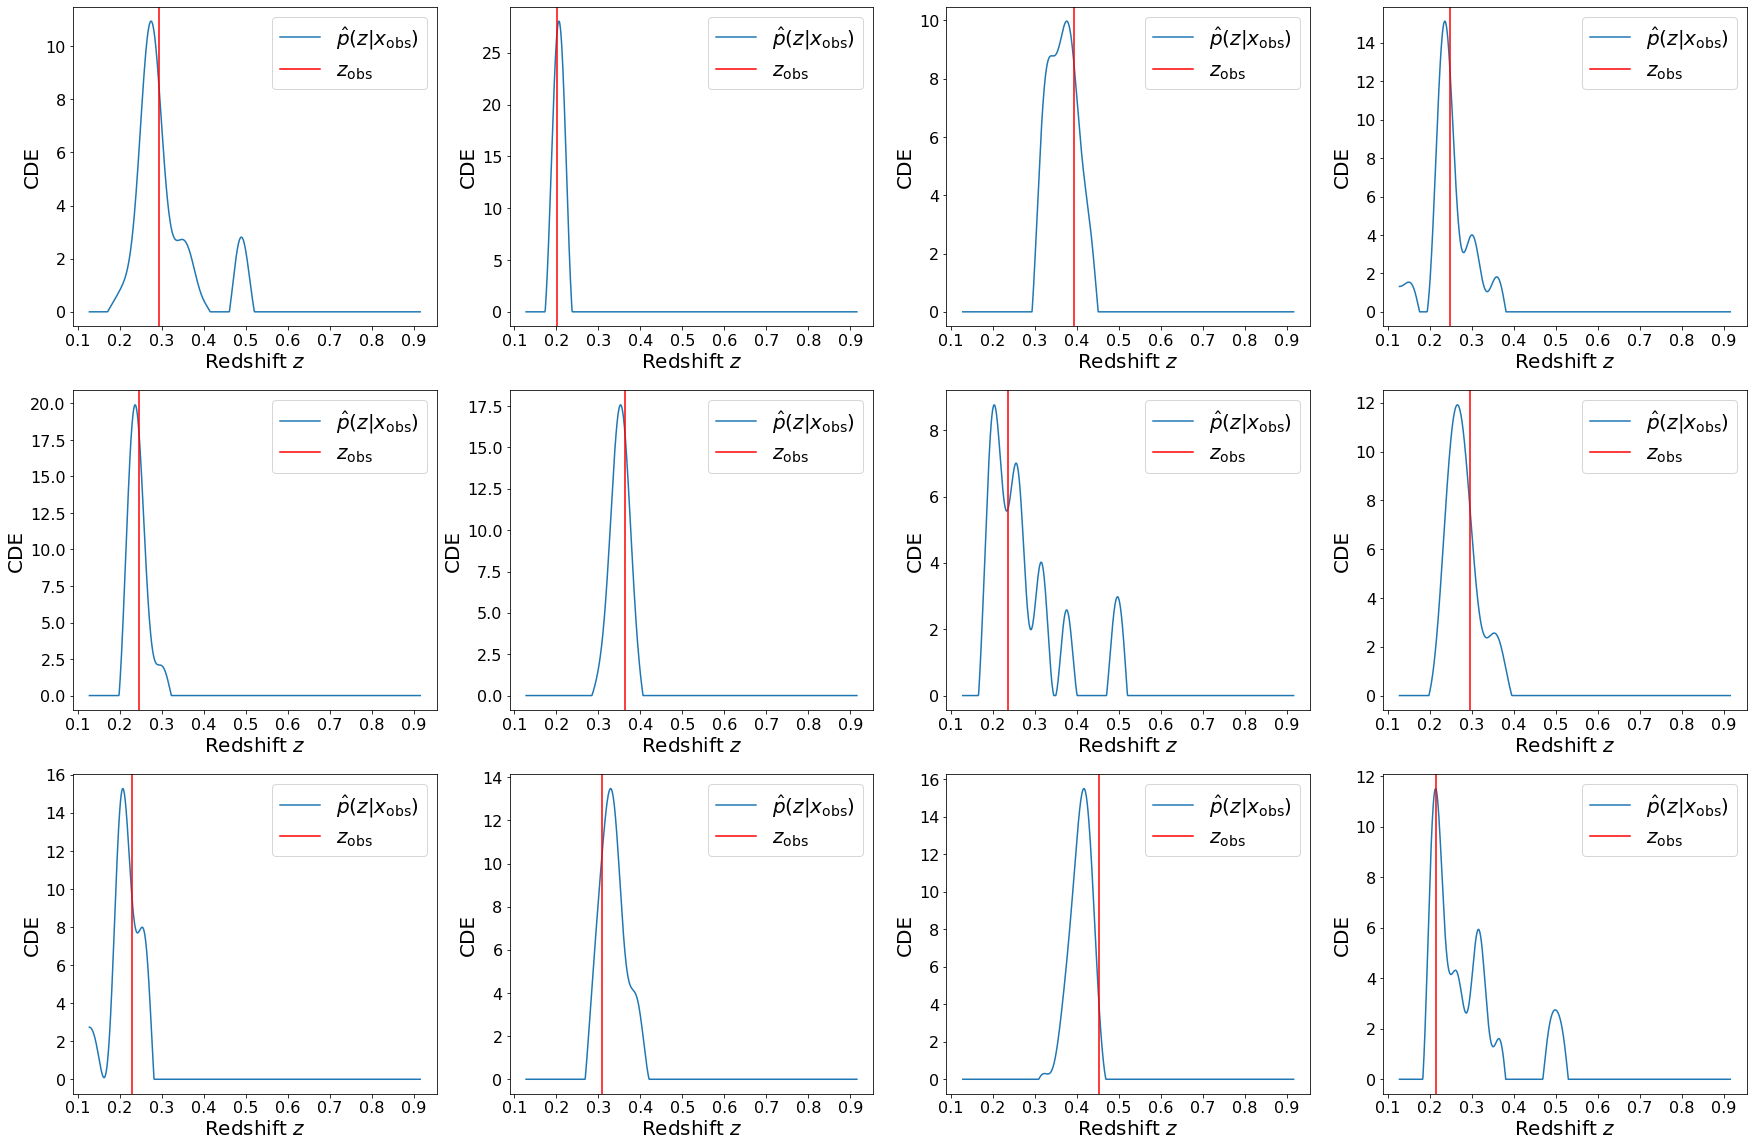

In [17]:
fig = plt.figure(figsize=(30, 20))
for jj, cde_predicted in enumerate(cde_test[:12,:]):
    ax = fig.add_subplot(3, 4, jj + 1)
    plt.plot(z_grid, cde_predicted, label=r'$\hat{p}(z| x_{\rm obs})$')
    plt.axvline(z_test[jj], color='red', label=r'$z_{\rm obs}$')
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel(r'Redshift $z$', size=20)
    plt.ylabel('CDE', size=20)
    plt.legend(loc='upper right', prop={'size': 20})
plt.show()

## Use Custom Regression Models

Flexcode can be used with any sklearn-compatible regression model. <br>
Here we show that the internal implementation of XGBoost (Gradient Boosted Trees Regression) and the XGBoost regressor from the `xgboost` package via Flexcode `CustomModel` yield identical results.

In [18]:
import xgboost as xgb
from flexcode.regression_models import XGBoost, CustomModel

Flexcode XGBoost Implementation

In [19]:
# Parameterize model
model = flexcode.FlexCodeModel(XGBoost, max_basis=31, basis_system="cosine",
                             regression_params={'max_depth': 3, 'learning_rate': 0.5, 'objective': 'reg:linear'})

# Fit and tune model
model.fit(x_train, z_train)
cdes_predict_xgb, z_grid = model.predict(x_test, n_grid=1000)

Flexcode Custom Model, using `XGBRegressor`

In [20]:
from xgboost import XGBRegressor

model_c = flexcode.FlexCodeModel(CustomModel, max_basis=31, basis_system="cosine",
                                 regression_params={'max_depth': 3, 'learning_rate': 0.5, 'objective': 'reg:linear'},
                                 custom_model=XGBRegressor)

# Fit and tune model
model_c.fit(x_train, z_train)
cdes_predict_custom, z_grid = model_c.predict(x_test, n_grid=1000)

We calculate the largest discrepancy between the two sets of predicted CDEs

In [21]:
np.max(np.abs(cdes_predict_custom - cdes_predict_xgb))

0.0

## CDE Diagnostics

We can compute the PIT and HPD values over our estimated CDEs. <br>
Functions to calculate both values can be found in the [`cdetools` package](https://github.com/tpospisi/cdetools).
<br>
We suggest to clone the Github repository and install it.

<code style="background:black;color:white">git clone https://github.com/tpospisi/cdetools.git </code> <br>
<code style="background:black;color:white">cd cdetools/python/ </code> <br>
<code style="background:black;color:white">python setup.py install </code> 

In [22]:
from cdetools.hpd_coverage import hpd_coverage
from cdetools.cdf_coverage import cdf_coverage
from cdetools.plot_utils import plot_with_uniform_band

# Computing the values
z_grid = np.linspace(z_train.min(), z_train.max(), n_grid)
pit_values = cdf_coverage(cde_test, z_grid, z_test)
hpd_values = hpd_coverage(cde_test, z_grid, z_test)

Computing the number of values per each bin in the histogram under uniformity assumptions. <br>
We look at the 99% CI.

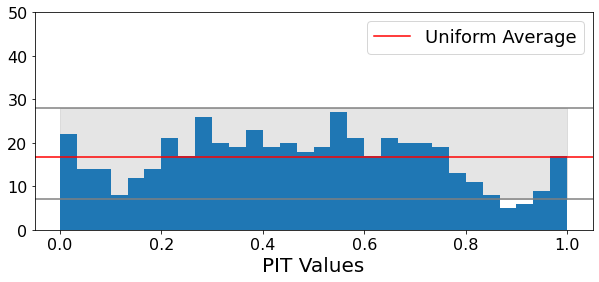

In [23]:
fig_pit = plot_with_uniform_band(values=pit_values, ci_level=0.99, x_label='PIT Values', n_bins=30)
fig_pit

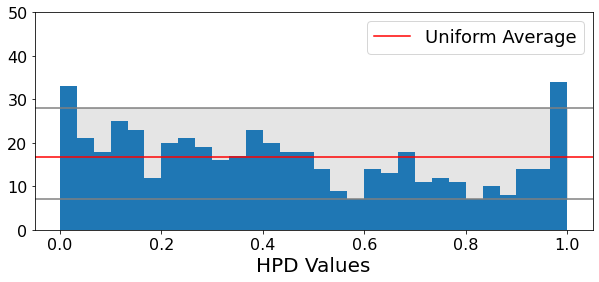

In [24]:
fig_hpd = plot_with_uniform_band(values=hpd_values, ci_level=0.99, x_label='HPD Values', n_bins=30)   
fig_hpd